In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/advanced-dls-spring-2021/submission.csv
/kaggle/input/advanced-dls-spring-2021/train.csv
/kaggle/input/advanced-dls-spring-2021/test.csv


In [2]:
# Импортируем все нужные библиотеки разом

from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_auc_score

In [3]:
# Знакомство с данными
train = pd.read_csv('/kaggle/input/advanced-dls-spring-2021/train.csv')
test = pd.read_csv('/kaggle/input/advanced-dls-spring-2021/test.csv')

train.info()
test.info()
# train.isna().any()
# test.isna().any()

# Видим, что в данных нет нулевых значений/пропусков, все векторы в матрице
# имеют одинаковую длину - хороший датасет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [4]:
# Проверяем, есть ли неправильно набранные категориальные признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

for column in cat_cols:
    print(column + ":", train[column].unique())
    
for column in num_cols:
    print(column + ": ", train[column].unique())

Sex: ['Male' 'Female']
IsSeniorCitizen: [0 1]
HasPartner: ['Yes' 'No']
HasChild: ['Yes' 'No']
HasPhoneService: ['Yes' 'No']
HasMultiplePhoneNumbers: ['No' 'Yes' 'No phone service']
HasInternetService: ['No' 'Fiber optic' 'DSL']
HasOnlineSecurityService: ['No internet service' 'No' 'Yes']
HasOnlineBackup: ['No internet service' 'No' 'Yes']
HasDeviceProtection: ['No internet service' 'No' 'Yes']
HasTechSupportAccess: ['No internet service' 'Yes' 'No']
HasOnlineTV: ['No internet service' 'No' 'Yes']
HasMovieSubscription: ['No internet service' 'No' 'Yes']
HasContractPhone: ['One year' 'Two year' 'Month-to-month']
IsBillingPaperless: ['No' 'Yes']
PaymentMethod: ['Mailed check' 'Credit card (automatic)' 'Electronic check'
 'Bank transfer (automatic)']
ClientPeriod:  [55 72  1 32 60 25 27 50 16 70 69 26 38 30 52 71 59 61  7 20 48 22  2 21
 44 66 58 46 45  5  4  3 62  6 39 68 51 40 10 43 12 35 31 67  8 11 29 37
 33 14 15 47 23 65 13 41 53  9 64 42 34 17 18 63 56 54 24 28 49 19 57 36
  0]
Mont

Вторая часть - анализ данных

In [60]:
all_cols = cat_cols + num_cols

all_cols

['Sex',
 'IsSeniorCitizen',
 'HasPartner',
 'HasChild',
 'HasPhoneService',
 'HasMultiplePhoneNumbers',
 'HasInternetService',
 'HasOnlineSecurityService',
 'HasOnlineBackup',
 'HasDeviceProtection',
 'HasTechSupportAccess',
 'HasOnlineTV',
 'HasMovieSubscription',
 'HasContractPhone',
 'IsBillingPaperless',
 'PaymentMethod',
 'ClientPeriod',
 'MonthlySpending',
 'TotalSpent']

In [5]:
train["TotalSpent"].shape

(5282,)

In [6]:
len(train["TotalSpent"])

5282

Построим гистограммы для числовых признаков.

На этом этапе становится понятным, что колонку "общие траты" нужно переводить в float формат - там везде строки вместо чисел

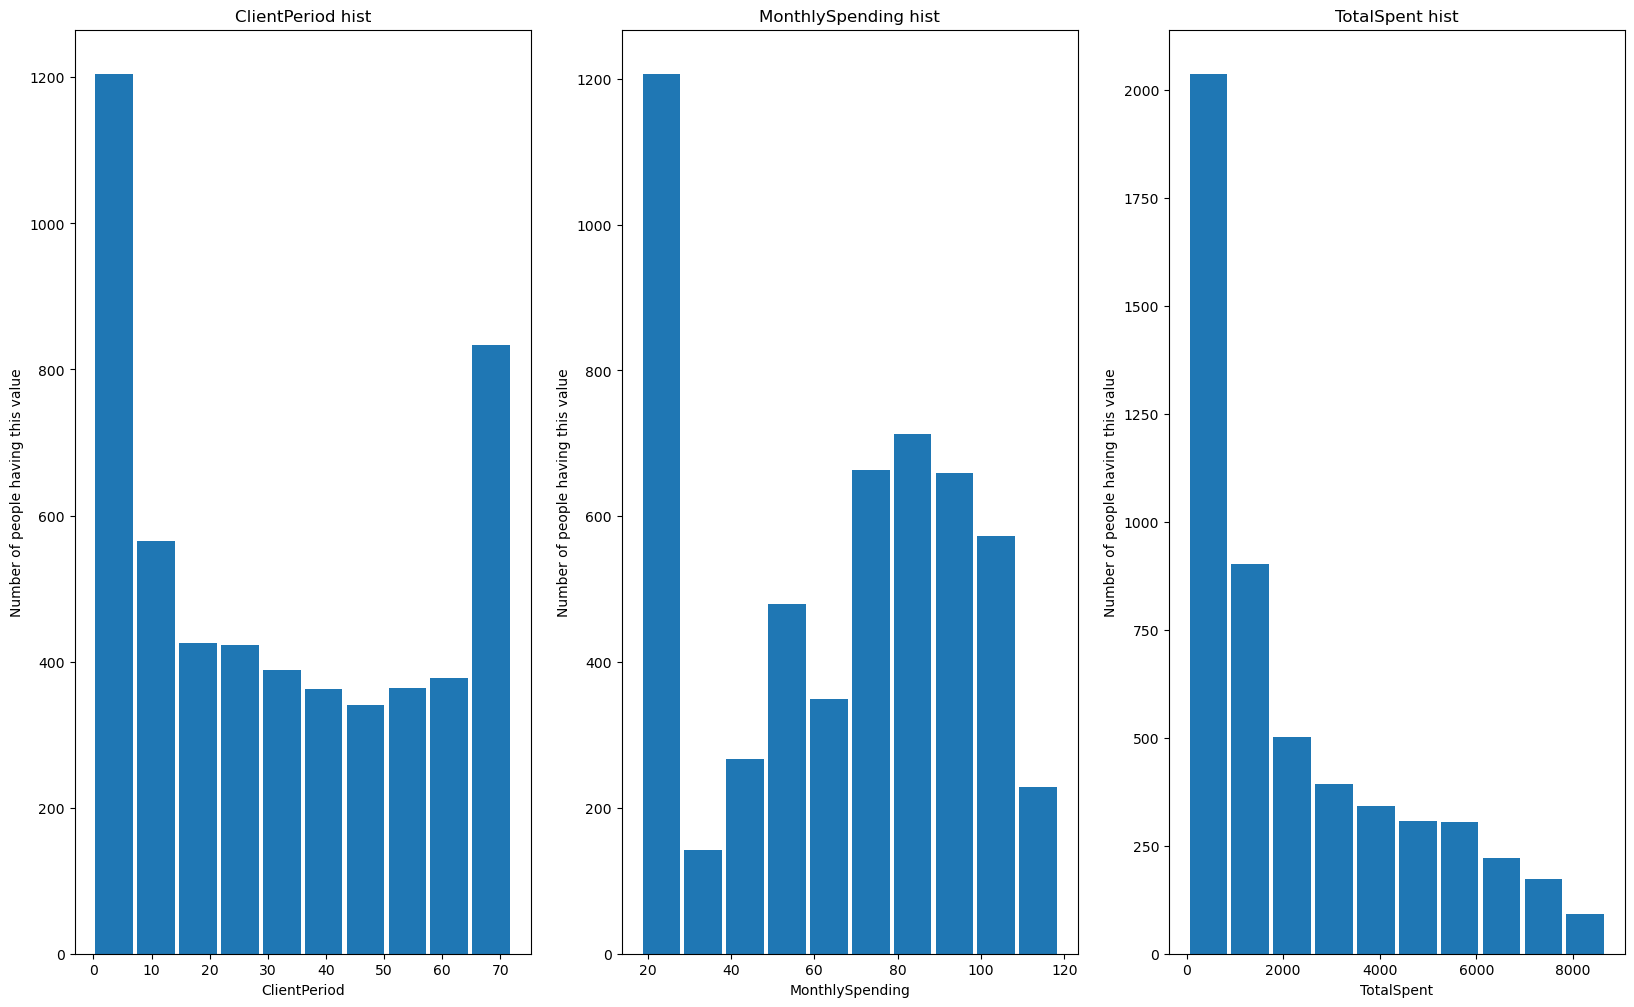

In [8]:
# Строим графики для численных фичей
i = 1
plt.figure(figsize = (20,12))
for column in num_cols:
    plt.subplot(1,3,i)
    plt.hist(pd.to_numeric(train[column], errors = 'coerce'), rwidth = 0.9)
    plt.xlabel(column)
    plt.ylabel("Number of people having this value")
    plt.title(column + " hist")
    i += 1

plt.show()

Видим, что ClientPeriod - двухпиковый график

MonthlySpending - бета-распределение с отрицаельным коэффициентом асимметрии (момент третьего порядка на std в кубе отрицательный) и пиком в левом "хвосте"

TotalSpent - половинка гауссоиды 

In [26]:
Попробуем boxplot

Сначала не получилось построить TotalSpent boxplot, т.к строил по методу plt.boxplot

Надо через .plot(kind = "box")

SyntaxError: invalid syntax (288251245.py, line 1)

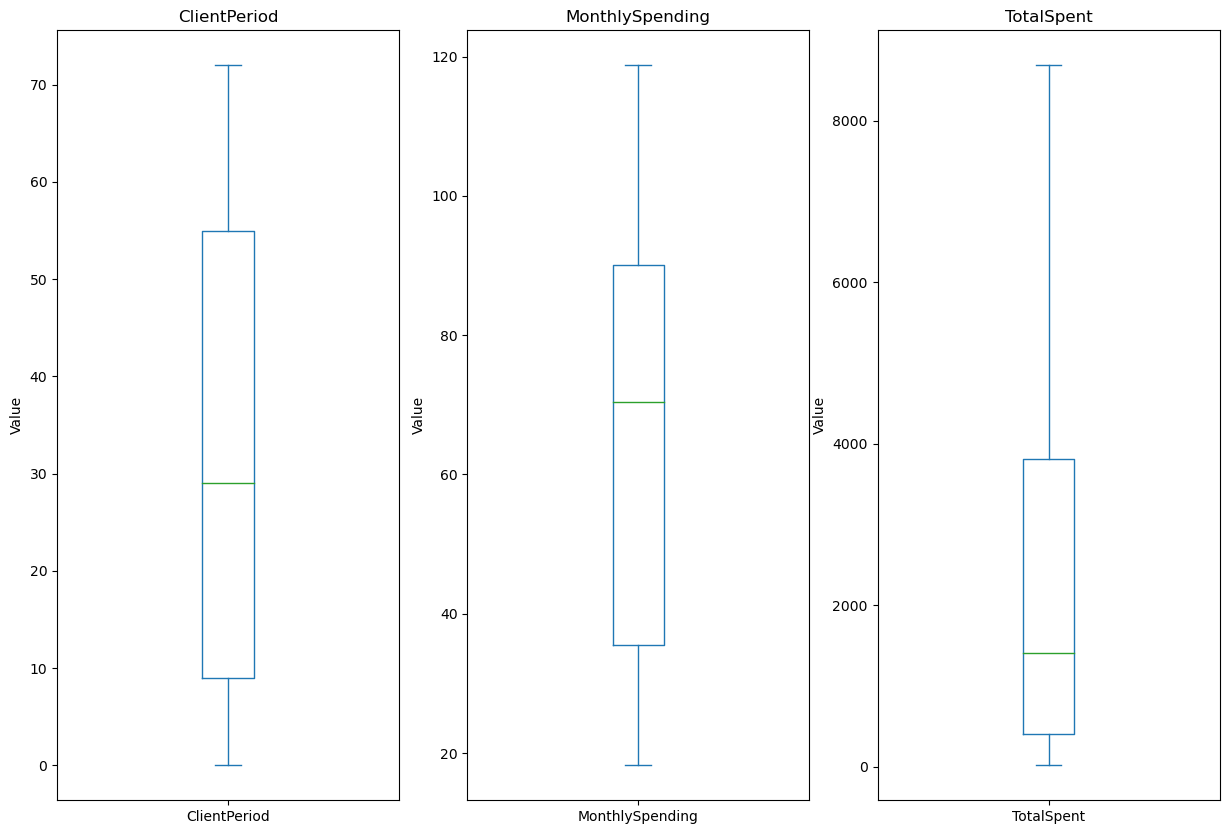

In [9]:
i = 1
plt.figure(figsize = (15,10))
for column in num_cols:
    plt.subplot(1,3,i)
    pd.to_numeric(train[column], errors = 'coerce').plot(kind = "box")
    plt.title(column)
    plt.ylabel("Value")
    i += 1
    
plt.show()

In [36]:
Построим теперь диаграммы для категориальных данных

SyntaxError: invalid syntax (1141245704.py, line 1)

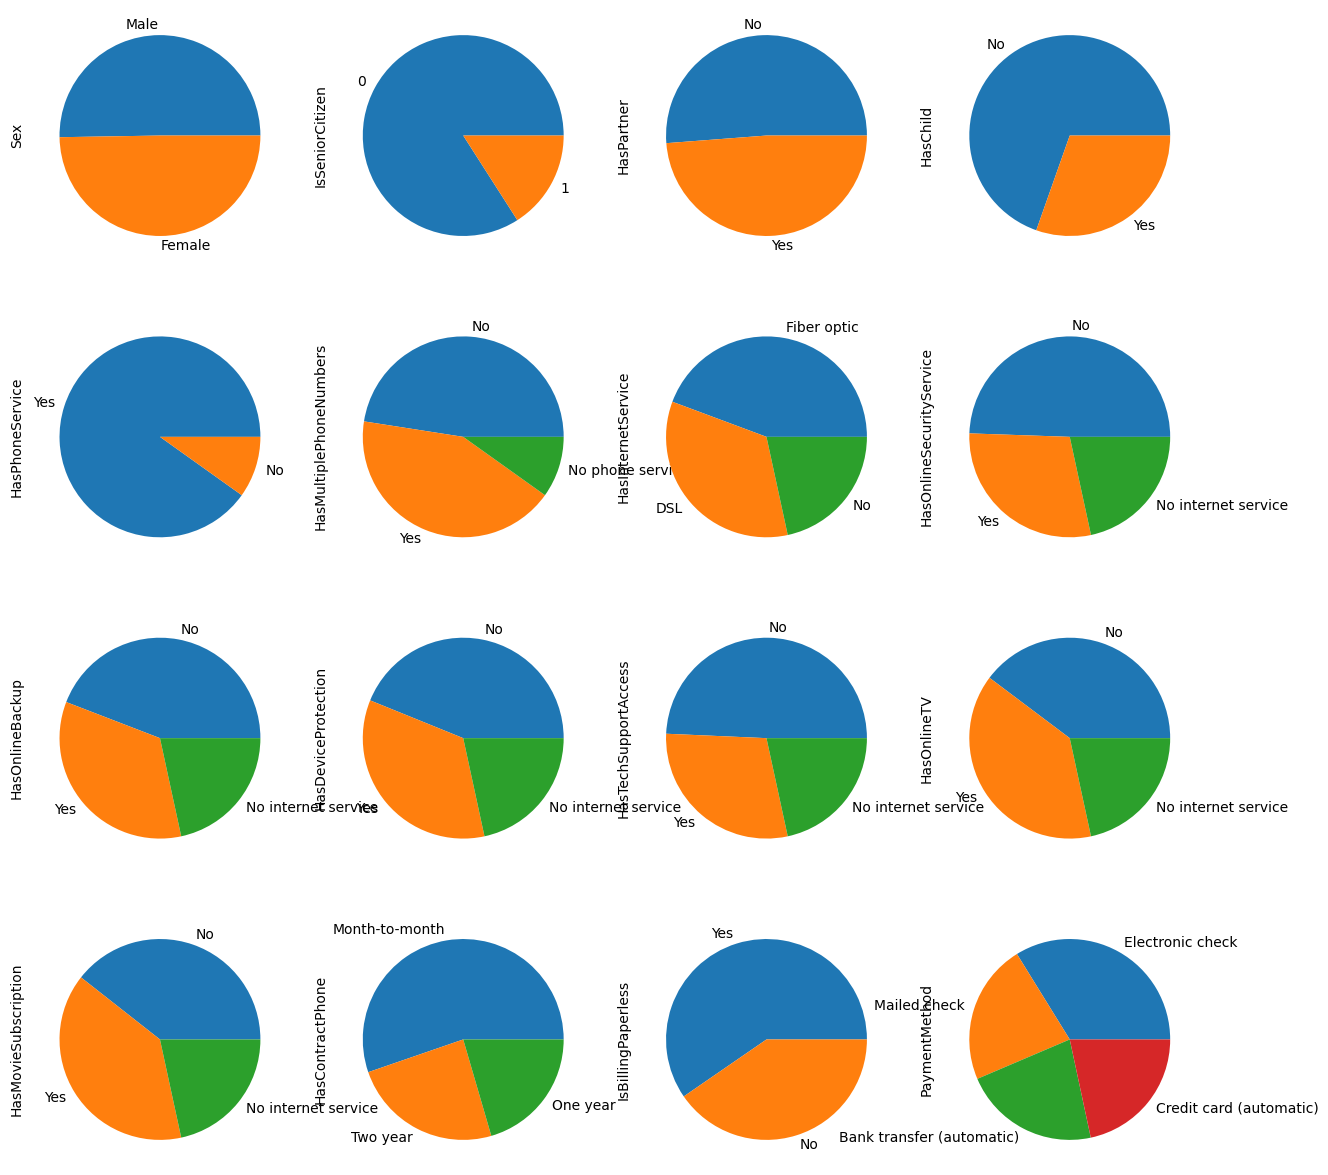

In [10]:
i = 1
plt.figure(figsize = (15,15))
for column in cat_cols:
    plt.subplot(4,4,i)
    train[column].value_counts().plot(kind = "pie")
    i = i+1

plt.show()

<AxesSubplot:ylabel='Churn'>

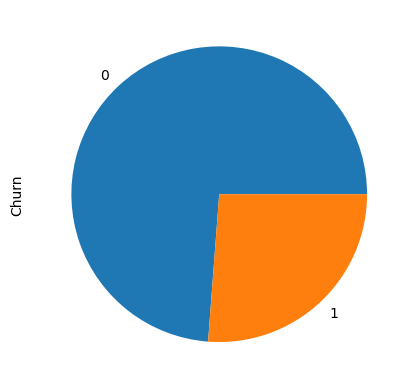

In [11]:
train["Churn"].value_counts().plot(kind = "pie")

Видим, что классы несбалансированные - класса "0" явно больше, чем класса "1"

ПРИМЕНЕНИЕ ЛИНЕЙНЫХ МОДЕЛЕЙ

Отнормируем численные данные, а к категориальным применим one-hot-encoding б

In [28]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, make_scorer, roc_curve

train["TotalSpent"] = pd.to_numeric(train["TotalSpent"], errors = "coerce")

# Нормируем числовые признаки

scaler = StandardScaler()
X_train_scaled_np = scaler.fit_transform(train[num_cols])

X_train_scaled = pd.DataFrame(X_train_scaled_np, columns = num_cols)

X_train_scaled

,ClientPeriod,MonthlySpending,TotalSpent
0,0.920767,-1.505447,-0.557582
1,1.613288,-1.294998,-0.184763
2,-1.279005,0.363737,-0.976504
3,-0.016173,0.476418,0.122800
4,1.124450,1.667856,1.968909
...,...,...,...
5277,-1.197532,-1.144204,-0.973749
5278,0.717084,-0.678565,-0.045372
5279,-1.279005,-0.327265,-0.985693
5280,-0.138382,0.367051,-0.033560


One-hot-encoding для категориальных данных:

In [14]:
X_train_cat = pd.get_dummies(train[cat_cols])

#

Соединим категориальные и числовые данные, приведём все данные в единый вид - дропнем все отсутствующие значения для таргета и фичей: 

In [15]:
X_train = pd.concat([X_train_scaled, X_train_cat], axis = 1)
X_train = pd.concat([X_train, train[target_col]], axis = 1)
X_train = X_train.fillna(value = 0)

y_train = X_train["Churn"]
X_train = X_train.drop("Churn", axis = 1)

Данные подготовлены, попробуем несколько линейных моделей:

In [16]:
def search_and_draw(X, y, model, param_name, grid, param_scale='ordinary', draw=True):
    parameters = {param_name: grid}
    
    CV_model = GridSearchCV(estimator=model, 
                            param_grid=parameters,
                            cv=5, 
                            scoring='roc_auc',
                            n_jobs=-1, 
                            verbose=10)
    CV_model.fit(X, y)
    means = CV_model.cv_results_['mean_test_score']
    error = CV_model.cv_results_['std_test_score']
    
    if draw:
        plt.figure(figsize=(15,8))
        plt.title('choose ' + param_name)


        if (param_scale == 'log'):
            plt.xscale('log')

        plt.plot(grid, means, label='mean values of score', color='red', lw=3)

        plt.fill_between(grid, means - 2 * error, means + 2 * error, 
                         color='green', label='filled area between errors', alpha=0.5)
        legend_box = plt.legend(framealpha=1).get_frame()
        legend_box.set_facecolor("white")
        legend_box.set_edgecolor("black")
        plt.xlabel('parameter')
        plt.ylabel('roc_auc')
        plt.show()
        
    return means, error

models = [LogisticRegression()]
param_names = ["C", "penalty"]
grids = [[100, 10, 1, 0.1, 0.01, 0.001, 0.0001], ["l1", "l2", "elasticnet"]]
param_scales = ['log', 'ordinary']


Fitting 5 folds for each of 7 candidates, totalling 35 fits


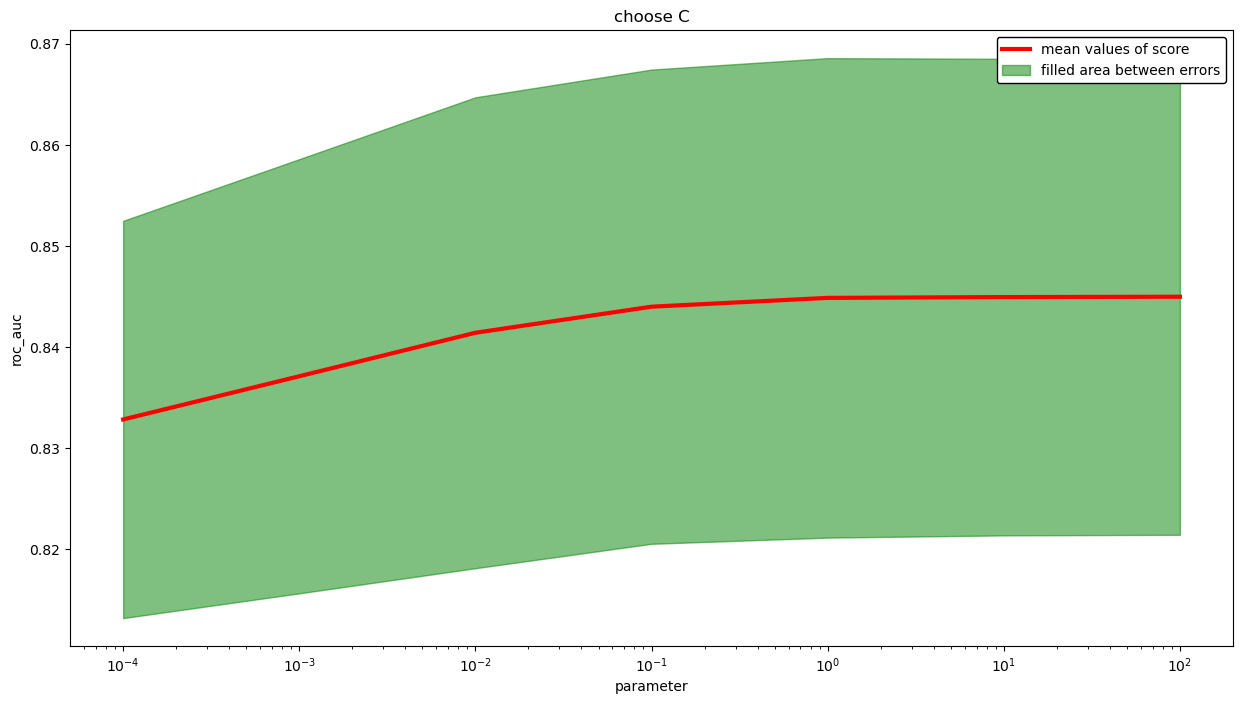

In [17]:
for model, param_name, grid, param_scale in zip(models, 
                                                param_names, 
                                                grids, 
                                                param_scales):
    search_and_draw(X_train, y_train, model, param_name, grid, param_scale)


In [18]:
CV_model = GridSearchCV(LogisticRegression(max_iter = 1000, solver = 'saga'),
                                           param_grid = {"C":[100, 10,1, 0.1],
                                           "penalty":['l1','l2','none']},
                                           scoring = 'roc_auc', n_jobs = -1, 
                                           verbose = 0, error_score = "raise")

CV_model.fit(X_train, y_train)

print(CV_model.best_score_)
print(CV_model.best_params_)

# plt.plot(CV_model.cv_results_["params"], CV_model.cv_results_["std_test_score"])

0.8449785721692032
{'C': 100, 'penalty': 'l2'}


In [19]:
test["TotalSpent"] = pd.to_numeric(test["TotalSpent"], errors = "coerce")

cols2_scaled_np = scaler.fit_transform(test[num_cols])

cols2_scaled = pd.DataFrame(cols2_scaled_np, columns = num_cols)

cols2_scaled_nina = cols2_scaled.fillna(value = 0)

X_test = pd.concat([cols2_scaled_nina, pd.get_dummies(test[cat_cols])], axis = 1) 
X_test = X_test.fillna(value = 0)
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 45 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   ClientPeriod                                  1761 non-null   float64
 1   MonthlySpending                               1761 non-null   float64
 2   TotalSpent                                    1761 non-null   float64
 3   IsSeniorCitizen                               1761 non-null   int64  
 4   Sex_Female                                    1761 non-null   uint8  
 5   Sex_Male                                      1761 non-null   uint8  
 6   HasPartner_No                                 1761 non-null   uint8  
 7   HasPartner_Yes                                1761 non-null   uint8  
 8   HasChild_No                                   1761 non-null   uint8  
 9   HasChild_Yes                                  1761 non-null   u

In [21]:
predictions = CV_model.predict_proba(X_test)

In [22]:
Id = pd.DataFrame(np.arange(1761))
data = pd.DataFrame(predictions)


submission = data.to_csv("submission.csv")

Получили искомые 0.84 ROC_AUC score. Ниже - пробуем RandomForest и получаем ROC_AUC 0.82 

In [ ]:
model = RandomForestClassifier(n_estimators=50, n_jobs=-1)

model.fit(X_train, y_train)
y_train_predicted = model.predict_proba(X_train)[:, 1]
y_test_predicted = model.predict_proba(X_test)[:, 1]

submissionForest = pd.DataFrame(y_test_predicted)
submissionForest = submissionForest.to_csv("submissionForest.csv")

Применим градиентный бустинг, пользуясь библиотекой catboos Яндекса: 

In [59]:
import catboost

In [77]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              1761 non-null   int64  
 1   MonthlySpending           1761 non-null   float64
 2   TotalSpent                1759 non-null   float64
 3   Sex                       1761 non-null   object 
 4   IsSeniorCitizen           1761 non-null   int64  
 5   HasPartner                1761 non-null   object 
 6   HasChild                  1761 non-null   object 
 7   HasPhoneService           1761 non-null   object 
 8   HasMultiplePhoneNumbers   1761 non-null   object 
 9   HasInternetService        1761 non-null   object 
 10  HasOnlineSecurityService  1761 non-null   object 
 11  HasOnlineBackup           1761 non-null   object 
 12  HasDeviceProtection       1761 non-null   object 
 13  HasTechSupportAccess      1761 non-null   object 
 14  HasOnlin

In [84]:

boosting_model = catboost.CatBoostClassifier(n_estimators=200, 
                                             cat_features=cat_cols)
all_cols = cat_cols + num_cols
X_train_origin = train[all_cols]
boosting_model.fit(X_train_origin, y_train)
X_test = X_test.fillna(value = 0)
y_test_predicted = boosting_model.predict_proba(test[all_cols])



y_test_predicted = pd.DataFrame(y_test_predicted)

Learning rate set to 0.091733
0:	learn: 0.6362397	total: 15.8ms	remaining: 3.15s
1:	learn: 0.5887386	total: 35.4ms	remaining: 3.51s
2:	learn: 0.5549235	total: 51.6ms	remaining: 3.39s
3:	learn: 0.5272608	total: 66.3ms	remaining: 3.25s
4:	learn: 0.5056647	total: 82.4ms	remaining: 3.21s
5:	learn: 0.4887109	total: 97.7ms	remaining: 3.16s
6:	learn: 0.4754969	total: 113ms	remaining: 3.13s
7:	learn: 0.4636367	total: 129ms	remaining: 3.1s
8:	learn: 0.4538398	total: 145ms	remaining: 3.08s
9:	learn: 0.4459779	total: 160ms	remaining: 3.04s
10:	learn: 0.4396228	total: 174ms	remaining: 2.99s
11:	learn: 0.4335448	total: 190ms	remaining: 2.98s
12:	learn: 0.4287466	total: 203ms	remaining: 2.93s
13:	learn: 0.4244070	total: 219ms	remaining: 2.92s
14:	learn: 0.4204978	total: 236ms	remaining: 2.91s
15:	learn: 0.4171098	total: 251ms	remaining: 2.88s
16:	learn: 0.4146284	total: 266ms	remaining: 2.87s
17:	learn: 0.4122456	total: 282ms	remaining: 2.85s
18:	learn: 0.4101229	total: 298ms	remaining: 2.84s
19:	le

In [85]:
y_test_predicted.to_csv("grad_submission.csv")

ROC-AUC этой модели получился 0.8528

Несколько строчек и никакой предобработки данных